### Import Required Libraries

In [1]:
# import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from tensorflow.keras import optimizers

# import other libraries
import string
import numpy as np
import re
from numpy import array, argmax, random, take
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'deep_learning/NMT/'
print(base_dir)

Mounted at /content/drive
/content/drive/My Drive/deep_learning/NMT/


### Read Data

Our data is a text file of English-Spanish parallel sentence pairs corpora. First we will read the file using the function defined below.

In [3]:
import os
# function to read raw text file
#filename = os.path.join(base_dir, spa.txt)
def read_text(filename):
    # open the file
    file = open(os.path.join(base_dir, filename), mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text
data = read_text("spa.txt")

Now let's define a function to split the text into English-Spanish pairs separated by '\n' and then split these pairs into English sentences and Spanish sentences.

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download other parallel corpora data from [here.](http://www.manythings.org/anki/)__ You can download "deu.txt" (german to english) in your working directory.

In [5]:
data = read_text("spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)
print(len(spa_eng))  # what is the number of lines of this file?

128084


The actual data contains over 128,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

#### **50 mil lineas**

In [6]:
spa_eng = spa_eng[:50000,:]
print(spa_eng)
print(len(spa_eng))

[['Go.' 'Ve.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)']
 ['Go.' 'Vete.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)']
 ['Go.' 'Vaya.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)']
 ...
 ['Please turn off the radio.' 'Por favor, apague la radio.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1198501 (cueyayotl)']
 ['Please turn off the radio.' 'Apagá la radio, por favor.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1215556 (El_mas_capo)']
 ['Please wake me up at 6:30.'
  'Por favor despiértame a las seis y media.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2429736 (CK) & #2429789 (kuma)']]
50000


#### **128000 lineas**


In [6]:
spa_eng = spa_eng
print(spa_eng)
print(len(spa_eng))

[['Go.' 'Ve.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)']
 ['Go.' 'Vete.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)']
 ['Go.' 'Vaya.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)']
 ...
 ['A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities. Some people try to reduce their carbon footprint because they are concerned about climate change.'
  'Una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades. Algunas personas intentan reducir su huella de carbono porque están preocupados acerca del cambio climático.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #1141316 (Source_VOA) & #1336787 (marcelostockle)']
 ['Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

50 mil lineas

In [7]:
spa_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Please turn off the radio.', 'Por favor, apague la radio.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1198501 (cueyayotl)'],
       ['Please turn off the radio.', 'Apagá la radio, por favor.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1215556 (El_mas_capo)'],
       ['Please wake me up at 6:30.',
        'Por favor despiértame a las seis y media.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2429736 (CK) & #2429789 (kuma)']],
      dtype='<U278')

128 mil lineas

In [7]:
spa_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities. Some people try to reduce their carbon footprint because they are concerned about climate change.',
        'Una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades. Algunas personas intentan reducir su huella de carbono porque están preocupados acerca del cambio climático.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1141316 (Source_VOA) & #1336787 (marcelostockle)'],
       ['Since there are usually multiple websites on any given to

We will get rid of the punctuation marks, and then convert the text to lower case.

In [8]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

50 mil lineas

In [9]:
spa_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Please turn off the radio', 'Por favor apague la radio',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1198501 (cueyayotl)'],
       ['Please turn off the radio', 'Apagá la radio por favor',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1215556 (El_mas_capo)'],
       ['Please wake me up at 630',
        'Por favor despiértame a las seis y media',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2429736 (CK) & #2429789 (kuma)']],
      dtype='<U278')

128 mil lineas

In [9]:
spa_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities Some people try to reduce their carbon footprint because they are concerned about climate change',
        'Una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades Algunas personas intentan reducir su huella de carbono porque están preocupados acerca del cambio climático',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1141316 (Source_VOA) & #1336787 (marcelostockle)'],
       ['Since there are usually multiple websites on any given topic I usua

In [10]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    spa_eng[i,1] = spa_eng[i,1].lower()  # sending over lowercase

50 mil lineas

In [11]:
spa_eng

array([['go', 've',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['go', 'vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['go', 'vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['please turn off the radio', 'por favor apague la radio',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1198501 (cueyayotl)'],
       ['please turn off the radio', 'apagá la radio por favor',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1215556 (El_mas_capo)'],
       ['please wake me up at 630',
        'por favor despiértame a las seis y media',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2429736 (CK) & #2429789 (kuma)']],
      dtype='<U278')

128 mil lineas

In [11]:
spa_eng

array([['go', 've',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['go', 'vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['go', 'vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['a carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities some people try to reduce their carbon footprint because they are concerned about climate change',
        'una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades algunas personas intentan reducir su huella de carbono porque están preocupados acerca del cambio climático',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1141316 (Source_VOA) & #1336787 (marcelostockle)'],
       ['since there are usually multiple websites on any given topic i usua

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model (By Google, the initial one !), we will have to convert both the input and the output sentences into integer sequences of __fixed length__. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and Spanish (German for the WorkShop), respectively.

In [12]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [13]:
#from pandas.core.arrays.datetimes import DataFrame
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
length_df.head(5)

,eng,spa
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


50 mil lineas

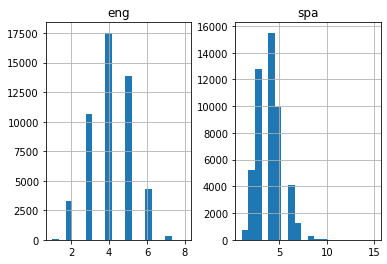

In [14]:
length_df.hist(bins = 20)
plt.show()

128 mil lineas

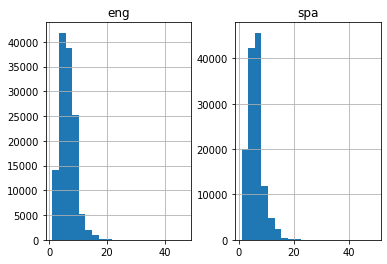

In [14]:
length_df.hist(bins = 20)
plt.show()

The maximum length of the English sentences is 8 and that of the English phrases is 10.

Let's vectorize our text data by using Keras' Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [15]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

50 mil lineas

In [16]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6861


128 mil lineas

In [17]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6861


50 mil lineas

In [18]:
# prepare Spanish - Deutch tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
#deu_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)
#print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Spanish Vocabulary Size: 14058


128 mil lineas

In [17]:
# prepare Spanish - Deutch tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
#deu_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)
#print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Spanish Vocabulary Size: 27807


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [19]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.1, random_state = 12)

It's time to encode the sentences. We will encode Spanish (German) sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [21]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length,train[:, 0])
trainY = encode_sequences(spa_tokenizer, spa_length,train[:, 1])

In [22]:
# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(spa_tokenizer, spa_length, test[:, 1])

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [22]:
# build NMT model (encoder-decoder)  Remember the U-Net for images, the same rationale !
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))

    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [23]:
model = build_model(eng_vocab_size, spa_vocab_size, eng_length, spa_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping (manually pick the model with the less distance between train and valid loss).

### **Modelo con 50 mil**

In [ ]:
epochs = 30
batch_size = 512

In [ ]:
filename = '/content/drive/My Drive/deep_learning/NMT/model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=epochs, batch_size=batch_size, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Let's compare the training loss and the validation loss.

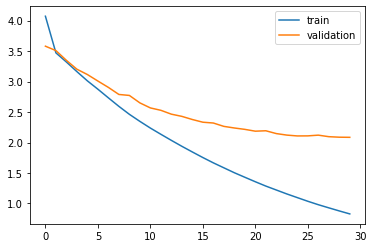

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

#### Make Predictions

Let's load the saved model to make predictions.

In [ ]:
preds = model.predict(testX).astype('float16')
preds = np.argmax(preds, axis=-1)

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if ((t == get_word(i[j-1], spa_tokenizer)) or (t == None)):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'predicted' : preds_text, 'spanish' : test[:,1], 'actual' : test[:,0]})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,predicted,spanish,actual
0,te pedí que me llamarais,les pedí que me llamaran,i asked you to call me
1,él es un aristócrata,él es dj,he is a dj
2,ellos quemaron,ellos discutieron,they quarreled
3,no miedo,no tengo miedo,im not scared
4,estoy harto para contigo,estoy listo para seguirte,i am ready to follow you
5,por favor el teléfono,por favor coge el teléfono,please answer the phone
6,ella se casarse con,le dijo adiós con la mano,she waved goodbye to him
7,el tom de tom se confiscado,el carro de tom fue confiscado,toms car was impounded
8,no pongáis excusas,no ponga excusas,dont make excuses
9,tienes ser más respetuoso,tienen que ser más respetuosos,you must be more polite


In [ ]:
pred_df.tail(15)

,predicted,spanish,actual
4985,por favor no de,por favor no llores de nuevo,please dont cry again
4986,me gustaría un,quisiera ver a un doctor,id like to see a doctor
4987,mi dolor es de,mi empresa tiene éxito,my company is successful
4988,¿puedes lo a tom,¿puedes encontrar a tom por mí,can you find tom for me
4989,tengo perdido mi,voy a tener mi venganza,ill have my revenge
4990,me un,me divertí,i had some fun
4991,tokio es una ciudad grande,tokio es una gran ciudad,tokyo is a big city
4992,él tiene un gran,tiene un cuello muy largo,he has a long neck
4993,tom está,tom está esperando,tom is waiting
4994,no era demasiado,no fui preocupado,i wasnt careful


In [ ]:
pred_df.sample(15)

,predicted,spanish,actual
2190,tom,tomás miente,tom lies
2890,él se golpeó en la,se pegó en la rodilla,he banged his knee
4109,ellos son nuestros,ellos son terribles enemigos,they are bitter enemies
3145,eso es ¿no es,eso es verdad ¿no es cierto,thats true isnt it
2586,él a más,él va a regresar a las cuatro,he will come back at four
705,tom nunca se enfermo,tom nunca ha estado enfermo,tom has never been sick
1688,los gente estaban,ambas historias son ciertas,both stories are true
2402,él vino en coche,ella llegó en un auto,she arrived in a car
1023,a madre no puede venir,mi madre no puede venir,my mother cant come
4245,yo soy un,yo soy maestro también,im also a teacher


### **Modelo con 128 mil**

In [26]:
epochs = 30
batch_size = 512

In [27]:
filename = '/content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=epochs, batch_size=batch_size, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
180/181 [============================>.] - ETA: 0s - loss: 4.8098
Epoch 1: val_loss improved from inf to 4.70317, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 46s 256ms/step - loss: 4.8095 - val_loss: 4.7032
Epoch 2/30
180/181 [============================>.] - ETA: 0s - loss: 4.4129
Epoch 2: val_loss improved from 4.70317 to 4.32179, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 45s 251ms/step - loss: 4.4127 - val_loss: 4.3218
Epoch 3/30
180/181 [============================>.] - ETA: 0s - loss: 4.0851
Epoch 3: val_loss improved from 4.32179 to 4.05759, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 48s 263ms/step - loss: 4.0851 - val_loss: 4.0576
Epoch 4/30
180/181 [============================>.] - ETA: 0s - loss: 3.7894
Epoch 4: val_loss improved from 4.05759 to 3.85200, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 46s 256ms/step - loss: 3.7894 - val_loss: 3.8520
Epoch 5/30
180/181 [============================>.] - ETA: 0s - loss: 3.5196
Epoch 5: val_loss improved from 3.85200 to 3.63954, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 49s 270ms/step - loss: 3.5195 - val_loss: 3.6395
Epoch 6/30
180/181 [============================>.] - ETA: 0s - loss: 3.2726
Epoch 6: val_loss improved from 3.63954 to 3.45230, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 47s 259ms/step - loss: 3.2725 - val_loss: 3.4523
Epoch 7/30
180/181 [============================>.] - ETA: 0s - loss: 3.0467
Epoch 7: val_loss improved from 3.45230 to 3.32806, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 47s 259ms/step - loss: 3.0467 - val_loss: 3.3281
Epoch 8/30
180/181 [============================>.] - ETA: 0s - loss: 2.8399
Epoch 8: val_loss improved from 3.32806 to 3.18894, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 47s 261ms/step - loss: 2.8400 - val_loss: 3.1889
Epoch 9/30
180/181 [============================>.] - ETA: 0s - loss: 2.6574
Epoch 9: val_loss improved from 3.18894 to 3.07139, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 47s 260ms/step - loss: 2.6576 - val_loss: 3.0714
Epoch 10/30
180/181 [============================>.] - ETA: 0s - loss: 2.4887
Epoch 10: val_loss improved from 3.07139 to 3.00950, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 47s 260ms/step - loss: 2.4888 - val_loss: 3.0095
Epoch 11/30
180/181 [============================>.] - ETA: 0s - loss: 2.3423
Epoch 11: val_loss improved from 3.00950 to 2.93051, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 47s 259ms/step - loss: 2.3421 - val_loss: 2.9305
Epoch 12/30
180/181 [============================>.] - ETA: 0s - loss: 2.2071
Epoch 12: val_loss improved from 2.93051 to 2.88122, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 48s 263ms/step - loss: 2.2072 - val_loss: 2.8812
Epoch 13/30
180/181 [============================>.] - ETA: 0s - loss: 2.0840
Epoch 13: val_loss did not improve from 2.88122
181/181 [==============================] - 35s 191ms/step - loss: 2.0840 - val_loss: 2.8924
Epoch 14/30
180/181 [============================>.] - ETA: 0s - loss: 1.9724
Epoch 14: val_loss improved from 2.88122 to 2.82674, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 47s 258ms/step - loss: 1.9723 - val_loss: 2.8267
Epoch 15/30
180/181 [============================>.] - ETA: 0s - loss: 1.8655
Epoch 15: val_loss improved from 2.82674 to 2.81908, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 47s 261ms/step - loss: 1.8655 - val_loss: 2.8191
Epoch 16/30
180/181 [============================>.] - ETA: 0s - loss: 1.7648
Epoch 16: val_loss did not improve from 2.81908
181/181 [==============================] - 35s 191ms/step - loss: 1.7648 - val_loss: 2.8303
Epoch 17/30
180/181 [============================>.] - ETA: 0s - loss: 1.6694
Epoch 17: val_loss improved from 2.81908 to 2.81317, saving model to /content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19


181/181 [==============================] - 47s 259ms/step - loss: 1.6693 - val_loss: 2.8132
Epoch 18/30
180/181 [============================>.] - ETA: 0s - loss: 1.5777
Epoch 18: val_loss did not improve from 2.81317
181/181 [==============================] - 35s 192ms/step - loss: 1.5779 - val_loss: 2.8375
Epoch 19/30
180/181 [============================>.] - ETA: 0s - loss: 1.4909
Epoch 19: val_loss did not improve from 2.81317
181/181 [==============================] - 34s 191ms/step - loss: 1.4909 - val_loss: 2.8271
Epoch 20/30
180/181 [============================>.] - ETA: 0s - loss: 1.4101
Epoch 20: val_loss did not improve from 2.81317
181/181 [==============================] - 34s 187ms/step - loss: 1.4101 - val_loss: 2.8321
Epoch 21/30
180/181 [============================>.] - ETA: 0s - loss: 1.3343
Epoch 21: val_loss did not improve from 2.81317
181/181 [==============================] - 34s 190ms/step - loss: 1.3344 - val_loss: 2.8595
Epoch 22/30
180/181 [===============

Let's compare the training loss and the validation loss.

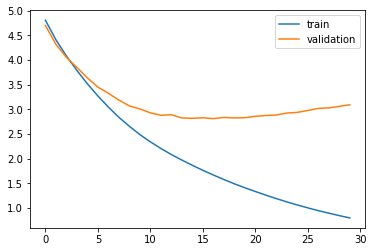

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

#### Make Predictions

Let's load the saved model to make predictions.

Para la prediccion usamos solo 50 mil datos

In [23]:
model = load_model('/content/drive/My Drive/deep_learning/NMT/model_128.h1.24_jan_19')


In [25]:
preds = model.predict(testX).astype('float16')
preds = np.argmax(preds, axis=-1)

In [26]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [27]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if ((t == get_word(i[j-1], spa_tokenizer)) or (t == None)):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [28]:
pred_df = pd.DataFrame({'predicted' : preds_text, 'spanish' : test[:,1], 'actual' : test[:,0]})

In [29]:
pd.set_option('display.max_colwidth', 200)

In [30]:
pred_df.head(15)

,predicted,spanish,actual
0,la en la en,les pedí que me llamaran,i asked you to call me
1,de,él es dj,he is a dj
2,,ellos discutieron,they quarreled
3,más el,no tengo miedo,im not scared
4,mi podría problema a problema,estoy listo para seguirte,i am ready to follow you
5,la que un salir,por favor coge el teléfono,please answer the phone
6,al lo no me,le dijo adiós con la mano,she waved goodbye to him
7,necesito él corriendo,el carro de tom fue confiscado,toms car was impounded
8,aprecio puedo un,no ponga excusas,dont make excuses
9,¿quieres no el ustedes,tienen que ser más respetuosos,you must be more polite


In [ ]:
pred_df.tail(15)

In [ ]:
pred_df.sample(15)

## **Conclusiones**

El modelo de 128 mil registros tuvo un peor rendimiento, con el set de validacion con un evidente overfitting. Además en el dataframe se evidencia que las traducciones son bastantes malas y sin coherencia. 

Para el modelo de 50 mil palabras se tiene una mejoria a través de las épocas, con un mejor rendimiento para el set de entrenamiento y con un overfitting evidente. 

A nivel de predicciones hay un comportamiento aceptable pero con bastantes errores en general, para ambos, pero con un mejor resultado para 50 mil registros. 

# **Aleman - Inglés**

## **Carga Datos**

In [ ]:
import os
# function to read raw text file
#filename = os.path.join(base_dir, spa.txt)
def read_text(filename):
    # open the file
    file = open(os.path.join(base_dir, filename), mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text
data = read_text("deu.txt")

In [ ]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [ ]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)
print(len(deu_eng))  # what is the number of lines of this file?

255817


In [ ]:
deu_eng = deu_eng[:50000,:]
print(deu_eng)
print(len(deu_eng))

[['Go.' 'Geh.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)']
 ['Hi.' 'Hallo!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)']
 ['Hi.' 'Grüß Gott!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)']
 ...
 ["They're coming again." 'Sie kommen wieder.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2243605 (CK) & #6643044 (Felixjp)']
 ["They're coming again." 'Die kommen wieder.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2243605 (CK) & #6645385 (Felixjp)']
 ["They're doing it now." 'Sie tun es jetzt.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #3740220 (CK) & #3815719 (nGerman)']]
50000


In [ ]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [ ]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Theyre coming again', 'Sie kommen wieder',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2243605 (CK) & #6643044 (Felixjp)'],
       ['Theyre coming again', 'Die kommen wieder',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2243605 (CK) & #6645385 (Felixjp)'],
       ['Theyre doing it now', 'Sie tun es jetzt',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3740220 (CK) & #3815719 (nGerman)']],
      dtype='<U537')

In [ ]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()  # sending over lowercase

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [ ]:
#from pandas.core.arrays.datetimes import DataFrame
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.head(5)

,eng,deu
0,1,1
1,1,1
2,1,2
3,1,1
4,1,1


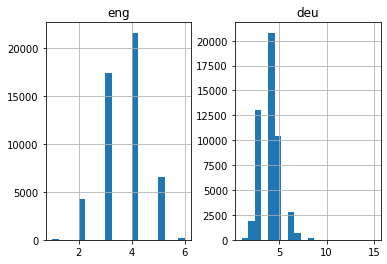

In [ ]:
length_df.hist(bins = 20)
plt.show()

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6125


In [ ]:
# prepare Spanish - Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

spa_length = 8
deu_length = 8
#print('Spanish Vocabulary Size: %d' % spa_vocab_size)
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10059


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.1, random_state = 12)

In [ ]:
trainX = encode_sequences(eng_tokenizer, eng_length,train[:, 0])
trainY = encode_sequences(deu_tokenizer, deu_length,train[:, 1])

In [ ]:
# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(deu_tokenizer, deu_length, test[:, 1])

In [ ]:
# build NMT model (encoder-decoder)  Remember the U-Net for images, the same rationale !
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))

    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
model = build_model(eng_vocab_size, deu_vocab_size, eng_length, deu_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = '/content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19'

## **Modelo con 50 mil**

In [ ]:
epochs = 30
batch_size = 512

In [ ]:
filename = '/content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=epochs, batch_size=batch_size, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
70/71 [============================>.] - ETA: 0s - loss: 3.7306
Epoch 1: val_loss improved from inf to 3.18443, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 29s 289ms/step - loss: 3.7285 - val_loss: 3.1844
Epoch 2/30
70/71 [============================>.] - ETA: 0s - loss: 3.0202
Epoch 2: val_loss improved from 3.18443 to 2.95603, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 18s 262ms/step - loss: 3.0196 - val_loss: 2.9560
Epoch 3/30
70/71 [============================>.] - ETA: 0s - loss: 2.7958
Epoch 3: val_loss improved from 2.95603 to 2.78744, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 263ms/step - loss: 2.7955 - val_loss: 2.7874
Epoch 4/30
70/71 [============================>.] - ETA: 0s - loss: 2.6379
Epoch 4: val_loss improved from 2.78744 to 2.69915, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 18s 261ms/step - loss: 2.6381 - val_loss: 2.6991
Epoch 5/30
70/71 [============================>.] - ETA: 0s - loss: 2.5035
Epoch 5: val_loss improved from 2.69915 to 2.56825, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 18s 262ms/step - loss: 2.5035 - val_loss: 2.5683
Epoch 6/30
70/71 [============================>.] - ETA: 0s - loss: 2.3874
Epoch 6: val_loss improved from 2.56825 to 2.48550, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 264ms/step - loss: 2.3872 - val_loss: 2.4855
Epoch 7/30
70/71 [============================>.] - ETA: 0s - loss: 2.2711
Epoch 7: val_loss improved from 2.48550 to 2.41947, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 18s 263ms/step - loss: 2.2713 - val_loss: 2.4195
Epoch 8/30
70/71 [============================>.] - ETA: 0s - loss: 2.1637
Epoch 8: val_loss improved from 2.41947 to 2.32547, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 265ms/step - loss: 2.1629 - val_loss: 2.3255
Epoch 9/30
70/71 [============================>.] - ETA: 0s - loss: 2.0591
Epoch 9: val_loss improved from 2.32547 to 2.23246, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 269ms/step - loss: 2.0596 - val_loss: 2.2325
Epoch 10/30
70/71 [============================>.] - ETA: 0s - loss: 1.9517
Epoch 10: val_loss improved from 2.23246 to 2.16177, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 268ms/step - loss: 1.9520 - val_loss: 2.1618
Epoch 11/30
70/71 [============================>.] - ETA: 0s - loss: 1.8486
Epoch 11: val_loss improved from 2.16177 to 2.08638, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 18s 263ms/step - loss: 1.8483 - val_loss: 2.0864
Epoch 12/30
70/71 [============================>.] - ETA: 0s - loss: 1.7503
Epoch 12: val_loss improved from 2.08638 to 2.01643, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 18s 262ms/step - loss: 1.7502 - val_loss: 2.0164
Epoch 13/30
70/71 [============================>.] - ETA: 0s - loss: 1.6534
Epoch 13: val_loss improved from 2.01643 to 1.97033, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 269ms/step - loss: 1.6529 - val_loss: 1.9703
Epoch 14/30
70/71 [============================>.] - ETA: 0s - loss: 1.5602
Epoch 14: val_loss improved from 1.97033 to 1.90777, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 265ms/step - loss: 1.5602 - val_loss: 1.9078
Epoch 15/30
70/71 [============================>.] - ETA: 0s - loss: 1.4732
Epoch 15: val_loss improved from 1.90777 to 1.86053, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 266ms/step - loss: 1.4735 - val_loss: 1.8605
Epoch 16/30
70/71 [============================>.] - ETA: 0s - loss: 1.3908
Epoch 16: val_loss improved from 1.86053 to 1.79372, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 265ms/step - loss: 1.3905 - val_loss: 1.7937
Epoch 17/30
70/71 [============================>.] - ETA: 0s - loss: 1.3123
Epoch 17: val_loss improved from 1.79372 to 1.78496, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 265ms/step - loss: 1.3120 - val_loss: 1.7850
Epoch 18/30
70/71 [============================>.] - ETA: 0s - loss: 1.2385
Epoch 18: val_loss improved from 1.78496 to 1.72741, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 276ms/step - loss: 1.2388 - val_loss: 1.7274
Epoch 19/30
70/71 [============================>.] - ETA: 0s - loss: 1.1700
Epoch 19: val_loss improved from 1.72741 to 1.69099, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 265ms/step - loss: 1.1700 - val_loss: 1.6910
Epoch 20/30
70/71 [============================>.] - ETA: 0s - loss: 1.1038
Epoch 20: val_loss improved from 1.69099 to 1.64789, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 267ms/step - loss: 1.1035 - val_loss: 1.6479
Epoch 21/30
70/71 [============================>.] - ETA: 0s - loss: 1.0395
Epoch 21: val_loss improved from 1.64789 to 1.64248, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 263ms/step - loss: 1.0401 - val_loss: 1.6425
Epoch 22/30
70/71 [============================>.] - ETA: 0s - loss: 0.9840
Epoch 22: val_loss improved from 1.64248 to 1.60070, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 272ms/step - loss: 0.9839 - val_loss: 1.6007
Epoch 23/30
70/71 [============================>.] - ETA: 0s - loss: 0.9265
Epoch 23: val_loss improved from 1.60070 to 1.57874, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 269ms/step - loss: 0.9268 - val_loss: 1.5787
Epoch 24/30
70/71 [============================>.] - ETA: 0s - loss: 0.8769
Epoch 24: val_loss improved from 1.57874 to 1.56901, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 267ms/step - loss: 0.8774 - val_loss: 1.5690
Epoch 25/30
70/71 [============================>.] - ETA: 0s - loss: 0.8293
Epoch 25: val_loss improved from 1.56901 to 1.55735, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 269ms/step - loss: 0.8295 - val_loss: 1.5573
Epoch 26/30
70/71 [============================>.] - ETA: 0s - loss: 0.7823
Epoch 26: val_loss improved from 1.55735 to 1.53984, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 275ms/step - loss: 0.7827 - val_loss: 1.5398
Epoch 27/30
70/71 [============================>.] - ETA: 0s - loss: 0.7400
Epoch 27: val_loss improved from 1.53984 to 1.53747, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 269ms/step - loss: 0.7401 - val_loss: 1.5375
Epoch 28/30
70/71 [============================>.] - ETA: 0s - loss: 0.6978
Epoch 28: val_loss improved from 1.53747 to 1.52362, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 19s 265ms/step - loss: 0.6977 - val_loss: 1.5236
Epoch 29/30
70/71 [============================>.] - ETA: 0s - loss: 0.6588
Epoch 29: val_loss did not improve from 1.52362
71/71 [==============================] - 6s 82ms/step - loss: 0.6590 - val_loss: 1.5357
Epoch 30/30
70/71 [============================>.] - ETA: 0s - loss: 0.6219
Epoch 30: val_loss improved from 1.52362 to 1.50900, saving model to /content/drive/My Drive/deep_learning/NMT/model_deu.h1.24_jan_19


71/71 [==============================] - 20s 282ms/step - loss: 0.6223 - val_loss: 1.5090


Let's compare the training loss and the validation loss.

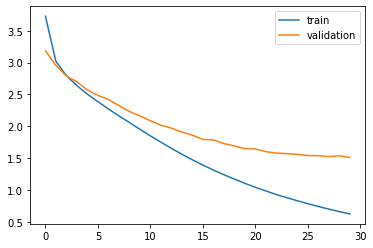

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

##### Make Predictions

Let's load the saved model to make predictions.

In [ ]:
preds = model.predict(testX).astype('float16')
preds = np.argmax(preds, axis=-1)

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], deu_tokenizer)
        if j > 0:
            if ((t == get_word(i[j-1], deu_tokenizer)) or (t == None)):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'predicted' : preds_text, 'deu' : test[:,1], 'actual' : test[:,0]})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,predicted,deu,actual
0,tom ist dein bruder,tom ist ihr bruder,tom is her brother
1,tom sprach,tom sprach,tom spoke
2,tom war früh,tom war früh dran,tom was early
3,sie wurde wütend,sie wurde wütend,she got angry
4,wann haben sie gekauft,wann hast du ihn gekauft,when did you buy it
5,bitte sie keine mühe,bitte mach dir keine mühe,please dont bother
6,gib mir zu,ruf mich nachher an,give me a call later
7,tom hat maria nicht,tom hat mary nicht gesehen,tom didnt see mary
8,hier ist ihr schreibtisch,hier ist dein schreibtisch,heres your desk
9,tom sah aus,tom sah erschöpft aus,tom looked fatigued


In [ ]:
pred_df.tail(15)

,predicted,deu,actual
4985,möchtet sie eis,möchtest du eis,would you like ice
4986,ist was das,alles ist möglich,anything is possible
4987,gefällt sie diese,meinen sie dieses,do you mean this one
4988,ich denke nicht,ich verstehe nicht warum nicht,i dont see why not
4989,tom hat gegen die verlassen,tom zerbrach die tasse,tom broke the cup
4990,es wird nicht schaden,es wird nicht schaden,it wont hurt
4991,ich hasse diesen teppich,ich hasse diesen laden,i hate this store
4992,ich kann ich nicht ertragen,ich kann es nicht ertragen,i cant stand it
4993,wir werden es gut,uns wird es gut gehen,well be fine
4994,können sie mich hören,können sie mich hören,can you hear me


In [ ]:
pred_df.sample(15)

,predicted,deu,actual
4095,sie bist vorbereitet,du bist vorbereitet,youre prepared
3287,kann ich mich zurückrufen,kann ich dich zurückrufen,can i call you back
1874,ich ging zu fuß schule,ich bin zu fuß zur schule gegangen,i walked to school
3458,es gibt keine hoffnung,es gibt keinen zweifel,theres no doubt
1614,sie bist introvertiert,ihr seid introvertiert,youre introverted
1613,das ist was,das ist es was tom sagt,thats what tom says
3862,was haben sie gefunden,was haben sie gefunden,what did they find
4636,ich habe pizza,ich habe pizza bestellt,i ordered pizza
4154,ich liebe dich nicht,ich liebe sie nicht,i dont love you
1932,kann ich dich sprechen,kann ich sie sprechen,may i speak to you


# Conclusiones

Se crearon correctamente las predicciones para la traduccion de ingles a aleman, incluso mejor que para español - ingles, ya que no se observa overfitting y en general hay un descenso mas importante en el loss. En este caso se probo con 50000 lineas para evitar el mismo problema de OOM, y para obtener un vistazo general de la manera en que trabaja este modelo, que por lo que experimentamos cumple su función de una manera correcta, pero que requiere mucha capacidad computacional. 